<a href="https://colab.research.google.com/github/pearl-yu/foster_2023summer/blob/main/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#If opening in colab run this cell
!git clone https://github.com/pearl-yu/foster_2023summer
%cd foster_2023summer/

Cloning into 'foster_2023summer'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), 1.01 MiB | 578.00 KiB/s, done.
/content/foster_2023summer


In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

# some custom libraries!
import sys
sys.path.append("..")
#from ds_utils.decision_surface import *

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as cv

# Predicting Churn

This dataset includes:

- COLLEGE : college educated?
- INCOME	: income
- OVERAGE	: average overcharges per month
- LEFTOVER : average % leftover minutes per month
- HOUSE : value of dwelling (from census tract)
- HANDSET_PRICE : cost of phone
- OVER_15MINS_CALLS_PER_MONTH : average number of long calls per month
- AVERAGE_CALL_DURATION : average call duration
- REPORTED_SATISFACTION : reported level of satisfaction
- REPORTED_USAGE_LEVEL : self-reported usage level
- CONSIDERING_CHANGE_OF_PLAN : was customer considering changing plan?
- PROFITABILITY: proprietary profitability score for this customer
- LEAVE : whether customer left or stayed

In [3]:
import numpy as np
import pandas as pd

# If necessary change the path below so that it points to your file.
data_path = "churn2.csv" 

df = pd.read_csv(data_path)

df.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,PROFITABILITY,LEAVE
0,zero,45775,0,16,542626,230,1,6,unsat,little,no,4.11,STAY
1,one,30051,0,22,742564,203,1,4,unsat,little,considering,6.40,STAY
2,one,25068,220,0,492271,172,14,14,unsat,very_little,perhaps,5.37,STAY
3,zero,143508,59,43,766627,867,3,1,unsat,very_high,considering,4.08,LEAVE
4,one,22449,217,79,280064,246,17,2,very_unsat,little,never_thought,3.17,STAY


LEAVE    0.52265
STAY     0.47735
Name: LEAVE, dtype: float64


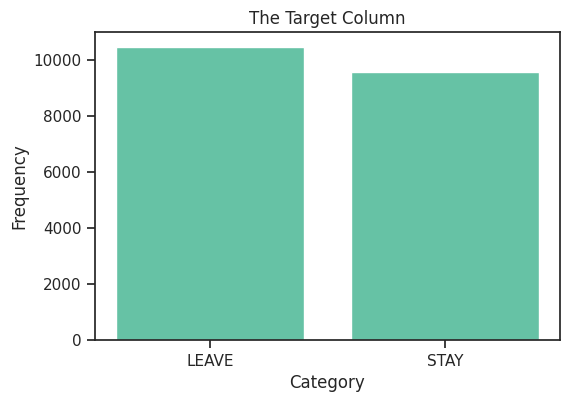

In [4]:
# take a look at the target column
fig = plt.figure(figsize=(6,4))
counts = df['LEAVE'].value_counts()
print(df["LEAVE"].value_counts()/df["LEAVE"].count())

plt.bar(counts.index, counts.values)
plt.title('The Target Column')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [5]:
# data preprocessing
df['LEAVE'] = np.where(df['LEAVE']=='LEAVE',1,0)
df = pd.get_dummies(df, drop_first=True)

In [6]:
# define the target and predictor columns
target = "LEAVE"
predictors = df.columns[df.columns != target]

X = df[predictors]
y = df["LEAVE"] 

# Take a look at what the decision trees look like when increaxing model complexity:

In [7]:
from IPython.display import Image
from sklearn.tree import export_graphviz

def visualize_tree(decision_tree, feature_names, class_names, directory="/content", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

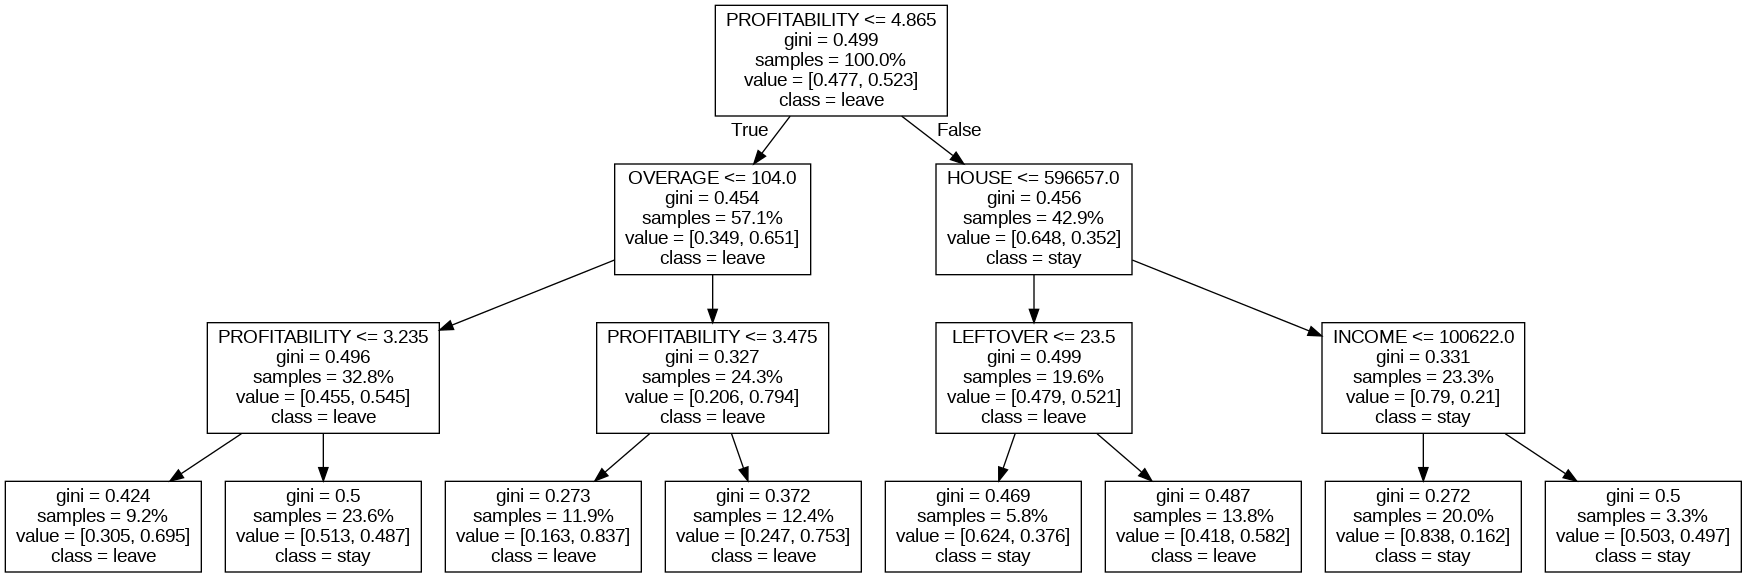

In [8]:
# You can change the parameter and parameter value
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
visualize_tree(model, predictors, ["stay", "leave"])

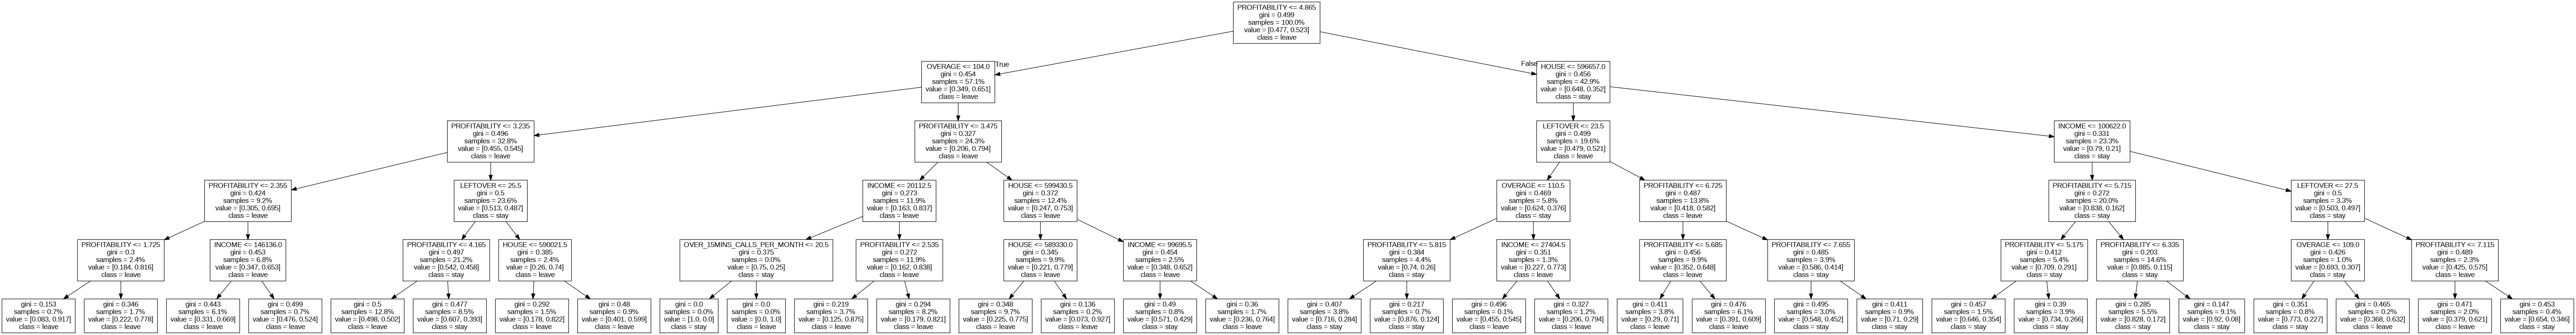

In [9]:
# You can change the parameter and parameter value
model = DecisionTreeClassifier(max_depth=5)
model.fit(X, y)
visualize_tree(model, predictors, ["stay", "leave"])

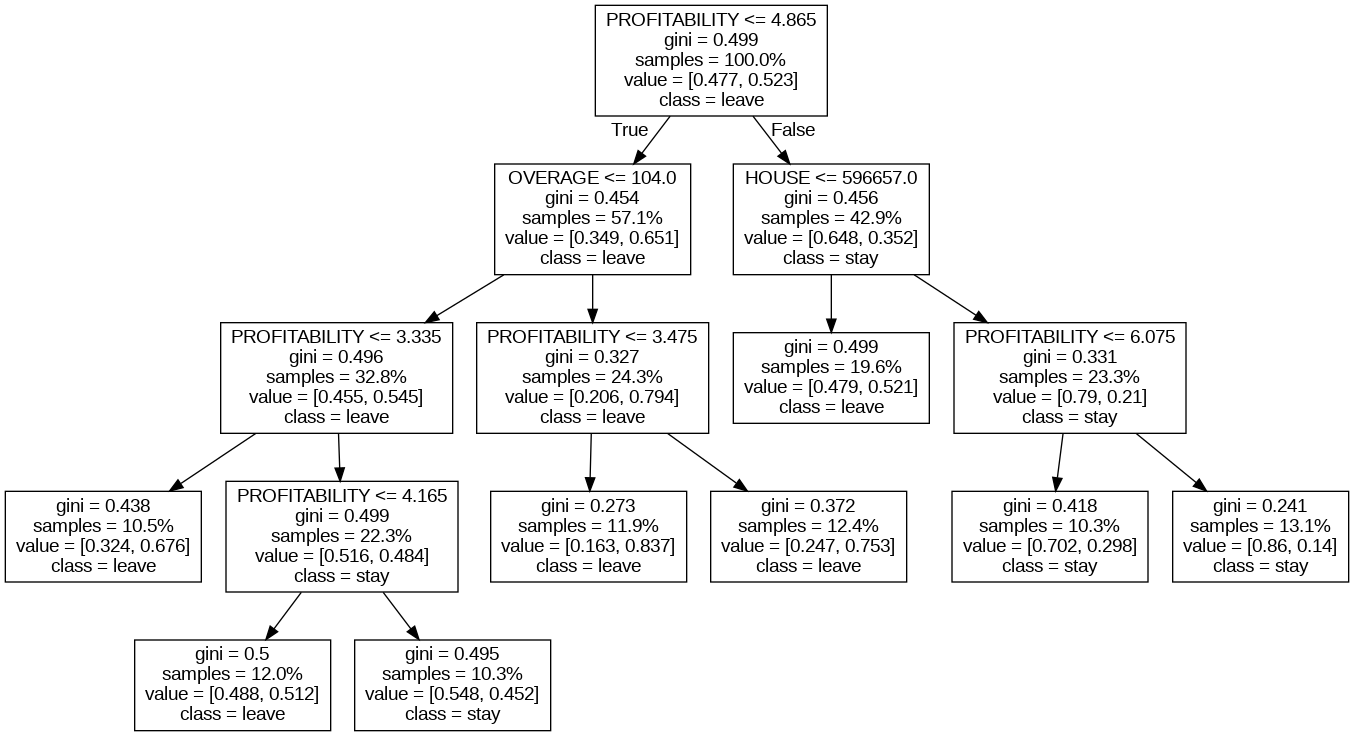

In [70]:
# You can change the parameter and parameter value
model = DecisionTreeClassifier(min_samples_leaf =2000)  #min_samples_leaf: the minimun number of samples in a leaf node
model.fit(X, y)
visualize_tree(model, predictors, ["stay", "leave"])

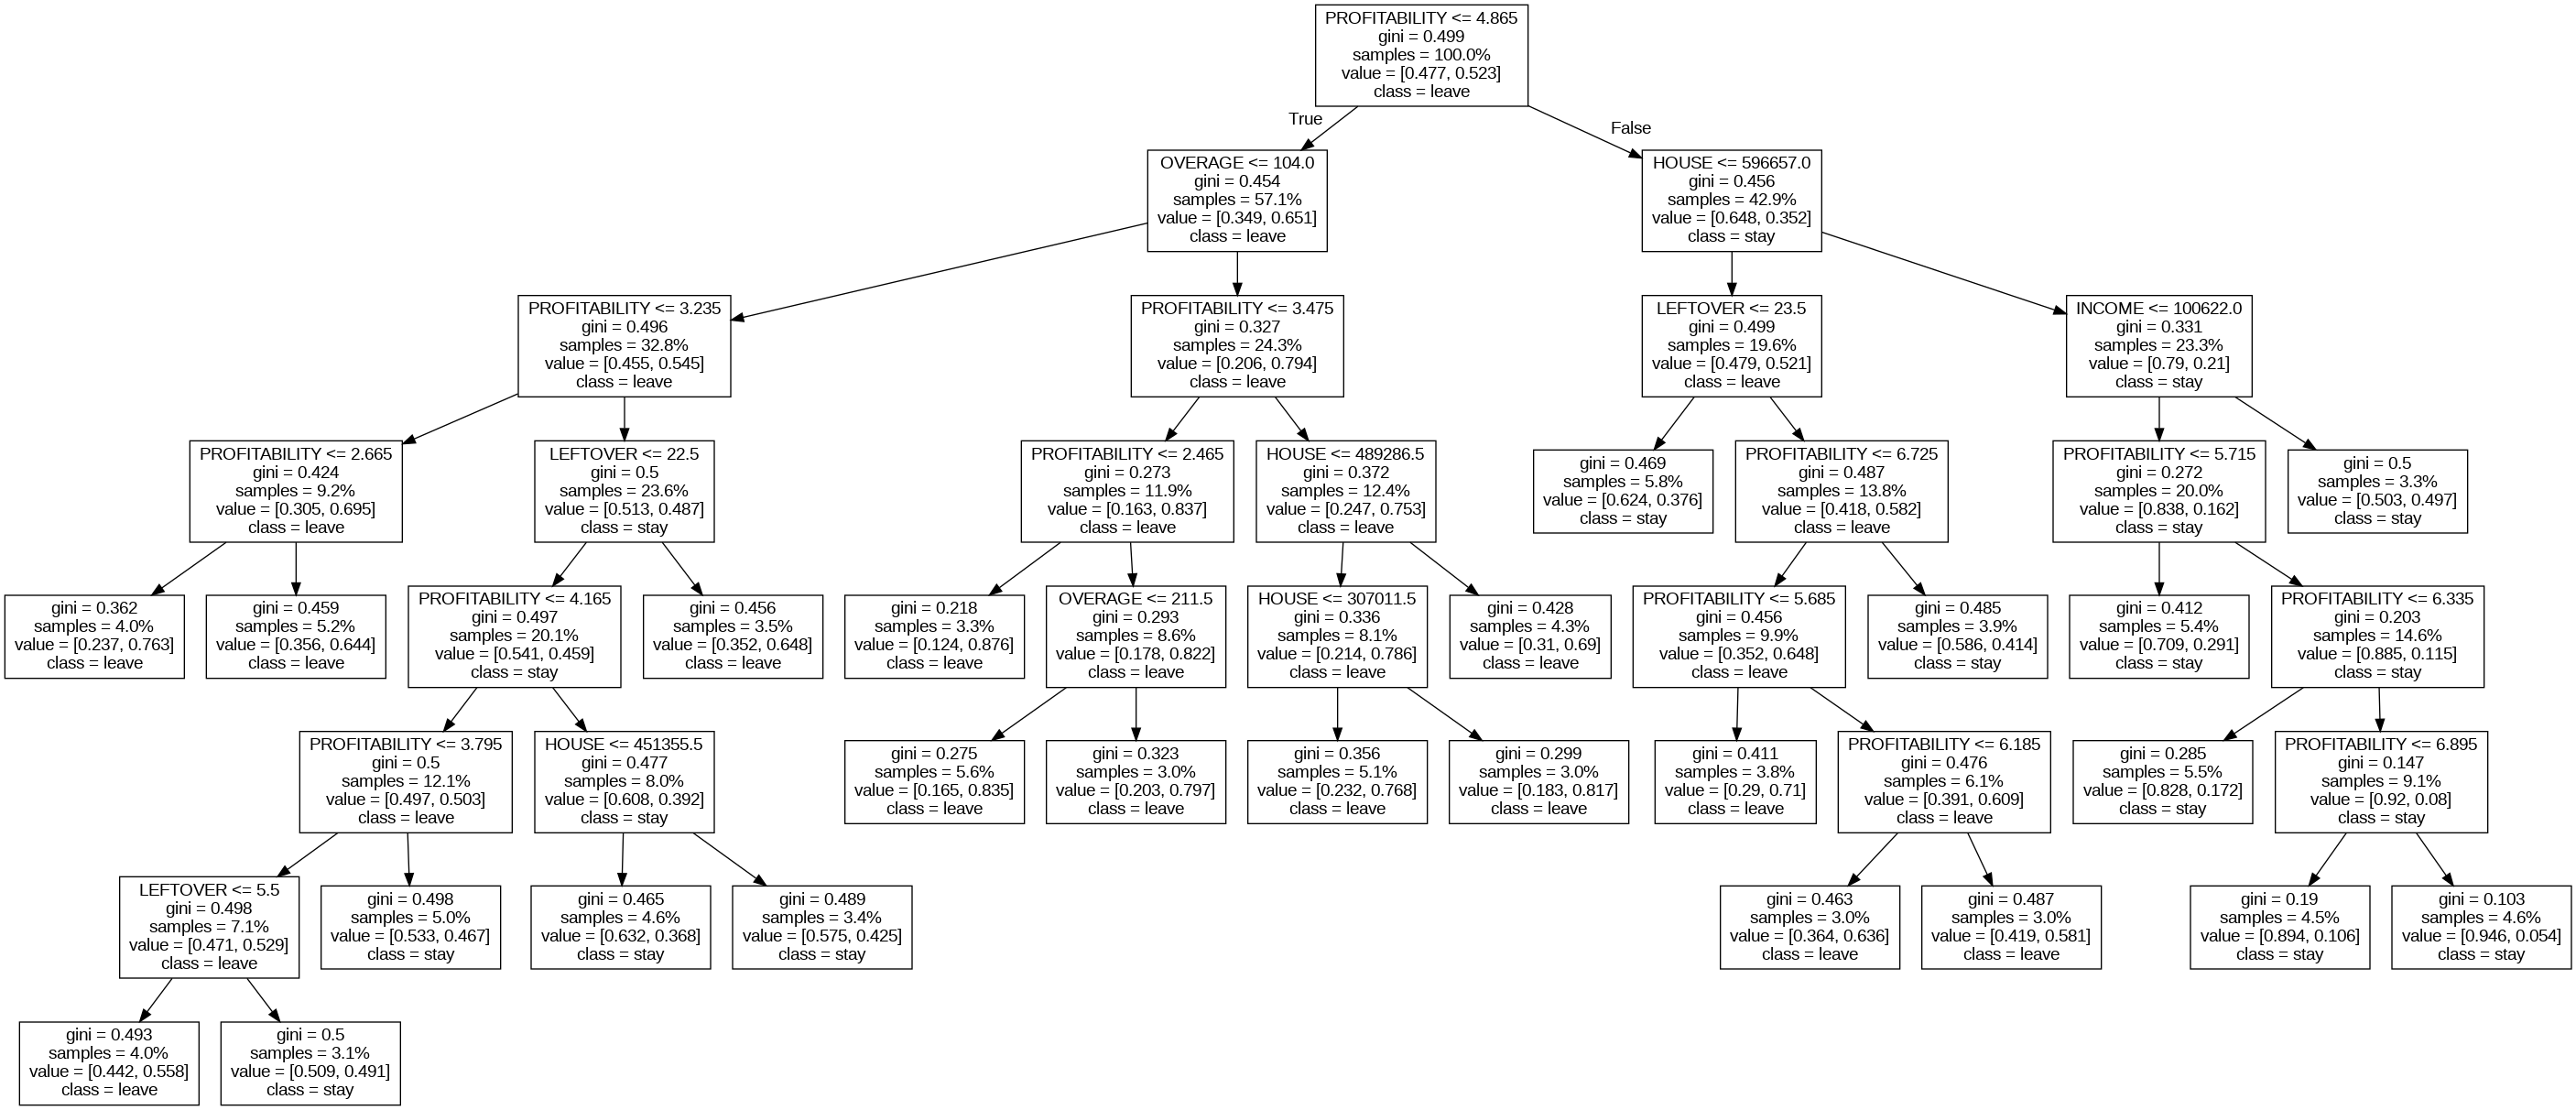

In [72]:
# You can change the parameter and parameter value
model = DecisionTreeClassifier(min_samples_leaf =600) #min_samples_leaf: the minimun number of samples in a leaf node
model.fit(X, y)
visualize_tree(model, predictors, ["stay", "leave"])

# Take a look at the training and cross-validated accuracies when increasing model complexity:

In [104]:
# fitting trees with increasing complexity
import matplotlib.pyplot as plt

list_cv = []
list_train = []
depth_val = []
max_depth = 1
while max_depth < 12:    
    model = DecisionTreeClassifier(max_depth=max_depth)  # complexity control via max tree depth
    model.fit(X, y)
    predictions = model.predict(X)
    train_acc = accuracy_score(predictions, y)
    cross_val_acc = cross_val_score(model, X, y, cv=5).mean()
    depth_val.append(max_depth)
    max_depth += 1
    list_cv.append(cross_val_acc)
    list_train.append(train_acc)

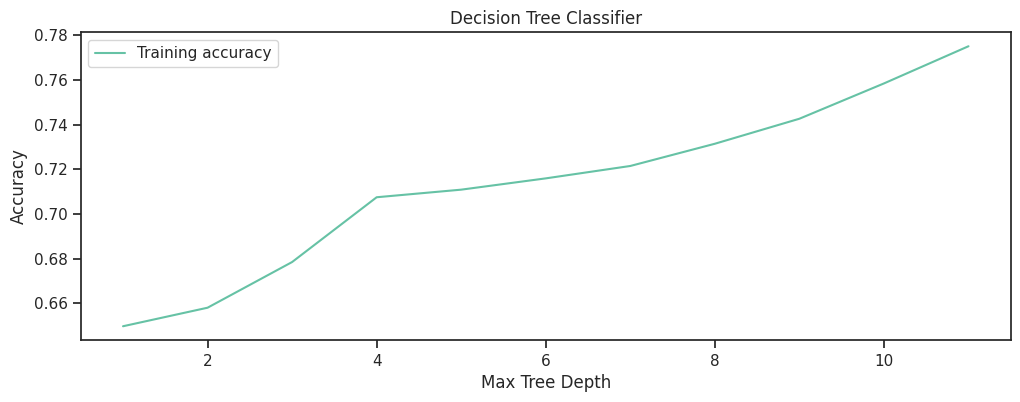

In [105]:
# plot accuracies
fig, (ax1) = plt.subplots(1, figsize=(12, 4))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#log_scale = np.log(max_depth)

# trining accuracy
ax1.plot(depth_val, list_train, label='Training accuracy')
ax1.legend()
ax1.set_xlabel("Max Tree Depth")
ax1.set_ylabel("Accuracy")
ax1.set_title('Decision Tree Classifier')

plt.show()

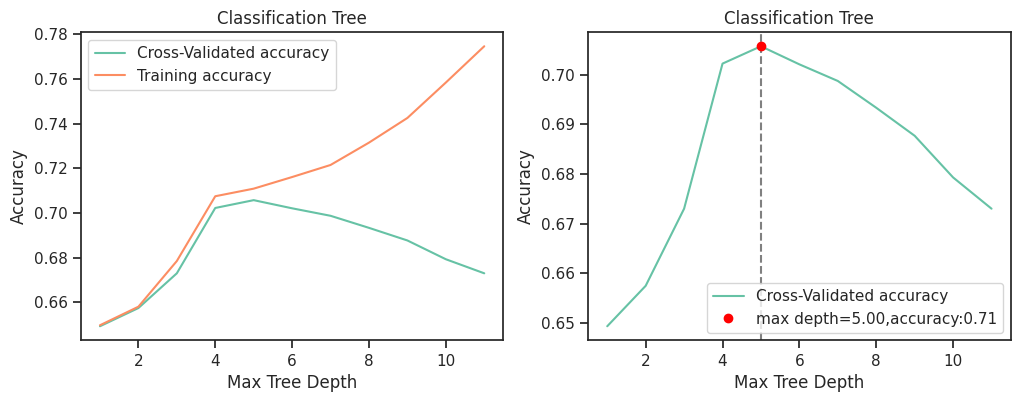

In [82]:
# plot fitting curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#log_scale = np.log(max_depth)

# trining and cross-validated accuracy
ax1.plot(depth_val, list_cv, label='Cross-Validated accuracy')
ax1.plot(depth_val, list_train, label='Training accuracy')
ax1.legend()
ax1.set_xlabel("Max Tree Depth")
ax1.set_ylabel("Accuracy")
ax1.set_title('Classification Tree')

# just the cross-validated accuracy
ax2.plot(depth_val, list_cv, label='Cross-Validated accuracy')
# find and plot the most appropriate value
max_index = np.argmax(list_cv)
max_x = depth_val[max_index]
max_y = list_cv[max_index]
ax2.axvline(x=max_x, color='gray', linestyle='--')
ax2.plot(max_x, max_y, 'ro',label=f"max depth={max_x:.2f},accuracy:{max_y:.2f}")
ax2.set_xlabel("Max Tree Depth")
ax2.set_ylabel("Accuracy")
ax2.set_title('Classification Tree')
ax2.legend()

plt.show()

What if we control the complexity by the minimum number of samples in a leaf node? 

In [84]:
# fitting trees with increasing complexity
import matplotlib.pyplot as plt

list_cv = []
list_train = []
leaf_val = []
leaf = 1
while leaf < 4097:    
    model = DecisionTreeClassifier(min_samples_leaf=leaf) # complexity control by setting min_samples_leaf
    model.fit(X, y)
    predictions = model.predict(X)
    train_acc = accuracy_score(predictions, y)
    cross_val_acc = cross_val_score(model, X, y, cv=5).mean()
    leaf_val.append(leaf)
    leaf = leaf*2
    list_cv.append(cross_val_acc)
    list_train.append(train_acc)

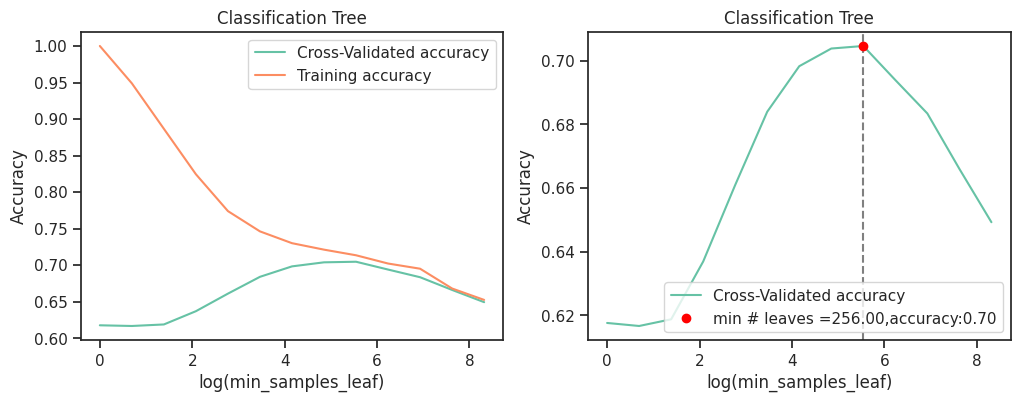

In [85]:
# plot fitting curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# trining and cross-validated accuracy
ax1.plot(np.log(leaf_val), list_cv, label='Cross-Validated accuracy')
ax1.plot(np.log(leaf_val), list_train, label='Training accuracy')
ax1.legend()
ax1.set_xlabel("log(min_samples_leaf)")
ax1.set_ylabel("Accuracy")
ax1.set_title('Classification Tree')

# just the cross-validated accuracy
ax2.plot(np.log(leaf_val), list_cv, label='Cross-Validated accuracy')
# find and plot the most appropriate value
max_index = np.argmax(list_cv)
max_x = leaf_val[max_index]
max_y = list_cv[max_index]
ax2.axvline(x=np.log(max_x), color='gray', linestyle='--')
ax2.plot(np.log(max_x), max_y, 'ro',label=f"min # leaves ={max_x:.2f},accuracy:{max_y:.2f}")
ax2.set_xlabel("log(min_samples_leaf)")
ax2.set_ylabel("Accuracy")
ax2.set_title('Classification Tree')
ax2.legend()

plt.show()

# Let's take a look at the logistic regression classifier

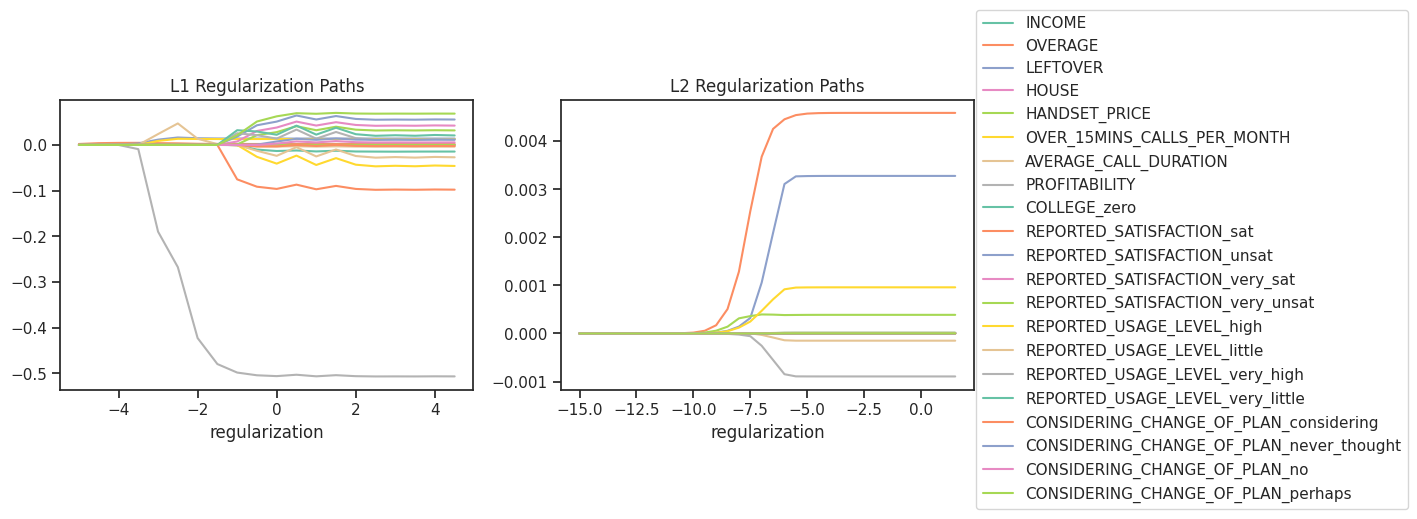

In [33]:
# plot the coefficients when changing regularization

def get_coeffs(X, Y, model):
    model.fit(X, Y)
    return dict(zip(X.columns, model.coef_[0]))

def get_lr_regularization_paths(X, Y, regtype, reg_values):
    coefs = [get_coeffs(X, Y, LogisticRegression(penalty=regtype, C=10**reg, solver='liblinear')) for reg in reg_values]
    df = pd.DataFrame(coefs)
    df["regularization"] = reg_values
    df.set_index("regularization", inplace=True)    
    return df

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

regs = np.arange(-10, 5, 0.5)

# Plot L1 regularization paths
regs = np.arange(-5, 5, 0.5)
l1_coefs = get_lr_regularization_paths(X, y, "l1", regs)
l1_coefs.plot(ax=axes[0])
axes[0].set_title("L1 Regularization Paths")
axes[0].legend_.remove()

# Plot L2 regularization paths
regs = np.arange(-15, 2, 0.5)
l2_coefs = get_lr_regularization_paths(X, y, "l2", regs)
l2_coefs.plot(ax=axes[1])
axes[1].set_title("L2 Regularization Paths")
axes[1].legend_.remove()

# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.2, 0.5), ncol=1)


plt.tight_layout()
plt.show()


In [115]:
# fitting models with differnt regularization params
import matplotlib.pyplot as plt

def regularazation_tune(penalty = 'l1',reg_val = np.arange(-10, 4, 0.2)):
  list_cv = []
  list_train = []
  depth_val = []
  max_depth = 1
  for reg in reg_val:   
    model = LogisticRegression(C=10**reg, penalty=penalty,solver='liblinear')
    model.fit(X, y)
    predictions = model.predict(X)
    train_acc = accuracy_score(predictions, y)
    cross_val_acc = cross_val_score(model, X, y, scoring='accuracy', cv=5).mean()
    list_cv.append(cross_val_acc)
    list_train.append(train_acc)

  return list_cv

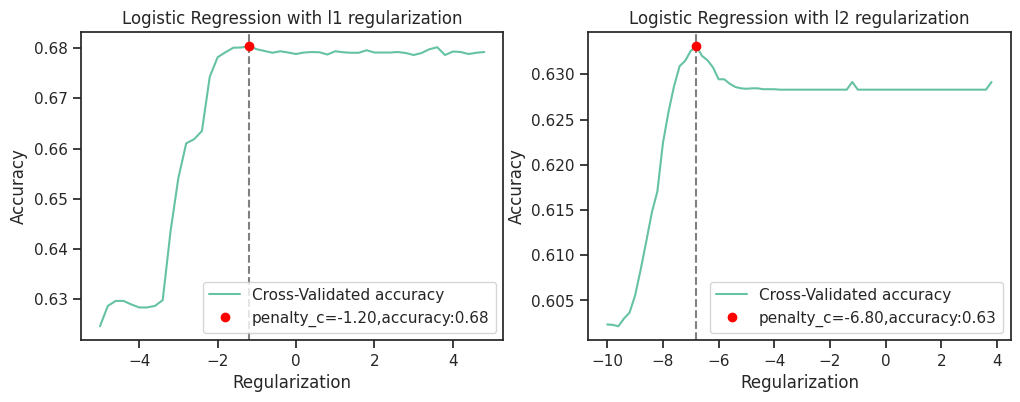

In [116]:
# This cell takes about 2 minutes to run
# plot fitting curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# l1 regularization
reg_vals = np.arange(-5, 5, 0.2)
list_cv = regularazation_tune('l1',reg_vals)
ax1.plot(reg_vals, list_cv, label='Cross-Validated accuracy')
max_index = np.argmax(list_cv)
max_x = reg_vals[max_index]
max_y = list_cv[max_index]
ax1.axvline(x=max_x, color='gray', linestyle='--')
ax1.plot(max_x, max_y, 'ro',label=f"penalty_c={max_x:.2f},accuracy:{max_y:.2f}")
ax1.legend()
ax1.set_xlabel("Regularization")
ax1.set_ylabel("Accuracy")
ax1.set_title('Logistic Regression with l1 regularization')

# l2 regularization
reg_vals = np.arange(-10, 4, 0.2)
list_cv = regularazation_tune('l2',reg_vals)
ax2.plot(reg_vals, list_cv, label='Cross-Validated accuracy')
max_index = np.argmax(list_cv)
max_x = reg_vals[max_index]
max_y = list_cv[max_index]
ax2.axvline(x=max_x, color='gray', linestyle='--')
ax2.plot(max_x, max_y, 'ro',label=f"penalty_c={max_x:.2f},accuracy:{max_y:.2f}")
ax2.legend()
ax2.set_xlabel("Regularization")
ax2.set_ylabel("Accuracy")
ax2.set_title('Logistic Regression with l2 regularization')
ax2.legend()

plt.show()

# The Learning Curves for model assessment

Please note that for this example, we're not tuning the hyperparameters for each point on the learning curve. 

In [86]:
def evaluate_model_on_sample(X, Y, model, pct, scoring=accuracy_score):
    kf = cv.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []    
    for train_index, test_index in kf.split(X, Y):  
        # only take a portion of the training data
        train_size = len(train_index)
        sampled_indices = np.random.permutation(train_index)[:int(pct*train_size)]
        model.fit(X.iloc[sampled_indices], Y[sampled_indices])
        scores.append(scoring(Y[test_index], model.predict(X.loc[test_index])))       
    return np.mean(scores)

In [ ]:
# This cell takes about 3 minutes to run.
pcts = np.linspace(0.01,1,100).tolist()
# Get scores for each classifier
dt_scores = [evaluate_model_on_sample(X, y, DecisionTreeClassifier(max_depth=5), pct) for pct in pcts]
lr_scores = [evaluate_model_on_sample(X, y, LogisticRegression(solver='liblinear', C=10**-1.4, penalty='l1'), pct) for pct in pcts]

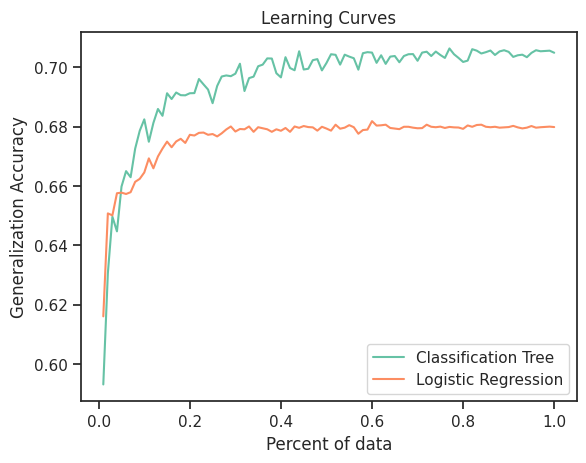

In [120]:
# Plot without confidence interval
plt.plot(pcts, dt_scores, label="Classification Tree")
plt.plot(pcts, lr_scores, label="Logistic Regression")
plt.xlabel("Percent of data")
plt.ylabel("Generalization Accuracy")
plt.title('Learning Curves')
plt.legend()
plt.show()

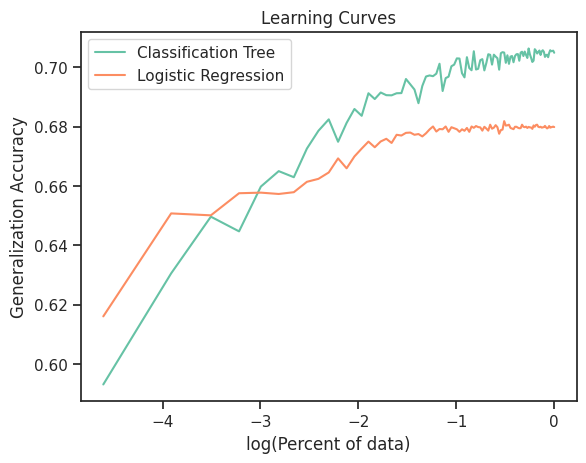

In [119]:
# Plot without confidence interval with log scale
plt.plot(np.log(pcts), dt_scores, label="Classification Tree")
plt.plot(np.log(pcts), lr_scores, label="Logistic Regression")
plt.xlabel("log(Percent of data)")
plt.ylabel("Generalization Accuracy")
plt.title('Learning Curves')
plt.legend()
plt.show()

***End of Notebook***